In [64]:
from sklearn.model_selection import train_test_split
import json

In [65]:
import sys
sys.path.append('../cyx＆xy/lattice/ner')

In [66]:
import warnings
warnings.filterwarnings("ignore")

In [67]:
warnings.simplefilter("ignore") 
warnings.warn("deprecated", DeprecationWarning)

In [68]:
import time
import sys
import argparse
import random
import copy
import torch
import json
import gc
import pickle
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from utils.metric import get_ner_fmeasure
from model.bilstmcrf import BiLSTM_CRF as SeqModel
from utils.data import Data

seed_num = 100
random.seed(seed_num)
torch.manual_seed(seed_num)
np.random.seed(seed_num)


def data_initialization(data, gaz_file, train_file, dev_file, test_file):
    data.build_alphabet(train_file)
    data.build_alphabet(dev_file)
    data.build_alphabet(test_file)
    data.build_gaz_file(gaz_file)

    #gaz_alphabet train,dev,test file在embedding中匹配到的词语
    data.build_gaz_alphabet(train_file)
    data.build_gaz_alphabet(dev_file)
    data.build_gaz_alphabet(test_file)
    data.fix_alphabet()
    return data


def predict_check(pred_variable, gold_variable, mask_variable):
    """
        input:
            pred_variable (batch_size, sent_len): pred tag result, in numpy format
            gold_variable (batch_size, sent_len): gold  result variable
            mask_variable (batch_size, sent_len): mask variable
    """
    pred = pred_variable.cpu().data.numpy()
    gold = gold_variable.cpu().data.numpy()
    mask = mask_variable.cpu().data.numpy()
    overlaped = (pred == gold)
    right_token = np.sum(overlaped * mask)
    total_token = mask.sum()
    # print("right: %s, total: %s"%(right_token, total_token))
    return right_token, total_token


def recover_label(pred_variable, gold_variable, mask_variable, label_alphabet, word_recover):
    """
        input:
            pred_variable (batch_size, sent_len): pred tag result
            gold_variable (batch_size, sent_len): gold result variable
            mask_variable (batch_size, sent_len): mask variable
    """
    
    pred_variable = pred_variable[word_recover]
    gold_variable = gold_variable[word_recover]
    mask_variable = mask_variable[word_recover]
    batch_size = gold_variable.size(0)
    seq_len = gold_variable.size(1)
    mask = mask_variable.cpu().data.numpy()
    pred_tag = pred_variable.cpu().data.numpy()
    gold_tag = gold_variable.cpu().data.numpy()
    batch_size = mask.shape[0]
    pred_label = []
    gold_label = []
    for idx in range(batch_size):
        pred = [label_alphabet.get_instance(pred_tag[idx][idy]) for idy in range(seq_len) if mask[idx][idy] != 0]
        gold = [label_alphabet.get_instance(gold_tag[idx][idy]) for idy in range(seq_len) if mask[idx][idy] != 0]
        # print "p:",pred, pred_tag.tolist()
        # print "g:", gold, gold_tag.tolist()
        assert(len(pred)==len(gold))
        pred_label.append(pred)
        gold_label.append(gold)
    return pred_label, gold_label


def save_data_setting(data, save_file):
    """
    new_data = copy.deepcopy(data)
    ## remove input instances
    new_data.train_texts = []
    new_data.dev_texts = []
    new_data.test_texts = []
    new_data.raw_texts = []
    new_data.train_Ids = []
    new_data.dev_Ids = []
    new_data.test_Ids = []
    new_data.raw_Ids = []"""
    ## save data settings
    with open(save_file, 'wb') as fp:
        pickle.dump(data, fp)
    print ("Data setting saved to file: ", save_file)


def load_data_setting(save_file):
    with open(save_file, 'rb') as fp:
        data = pickle.load(fp)
    print ("Data setting loaded from file: ", save_file)
    data.show_data_summary()
    return data

def lr_decay(optimizer, epoch, decay_rate, init_lr):
    lr = init_lr * ((1-decay_rate)**epoch)
    print (" Learning rate is setted as:", lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer



def evaluate(data, model, name):
    if name == "train":
        instances = data.train_Ids
    elif name == "dev":
        instances = data.dev_Ids
    elif name == 'test':
        instances = data.test_Ids
    elif name == 'raw':
        instances = data.raw_Ids
    else:
        print ("Error: wrong evaluate name,", name)
    pred_results = []
    gold_results = []
    ## set model in eval model
    model.eval()
    batch_size = 10
    start_time = time.time()
    train_num = len(instances)
    total_batch = train_num//batch_size+1
    for batch_id in range(total_batch):
        start = batch_id*batch_size
        end = (batch_id+1)*batch_size 
        if end >train_num:
            end =  train_num
        instance = instances[start:end]
        if not instance:
            continue
        gaz_list,batch_word, batch_biword, batch_wordlen, batch_wordrecover, batch_char, batch_charlen, batch_charrecover, batch_label, mask  = batchify_with_label(instance, data.HP_gpu, True)
        tag_seq = model(gaz_list,batch_word, batch_biword, batch_wordlen, batch_char, batch_charlen, batch_charrecover, mask)
        # print "tag:",tag_seq
        pred_label, gold_label = recover_label(tag_seq, batch_label, mask, data.label_alphabet, batch_wordrecover)
        pred_results += pred_label
        gold_results += gold_label
    decode_time = time.time() - start_time
    speed = len(instances)/decode_time
    acc, p, r, f, right_num = get_ner_fmeasure(gold_results, pred_results, data.tagScheme)
    return speed, acc, p, r, f, pred_results, right_num


def batchify_with_label(input_batch_list, gpu, volatile_flag=False):
    """
        input: list of words, chars and labels, various length. [[words,biwords,chars,gaz, labels],[words,biwords,chars,labels],...]
            words: word ids for one sentence. (batch_size, sent_len) 
            chars: char ids for on sentences, various length. (batch_size, sent_len, each_word_length)
        output:
            zero padding for word and char, with their batch length
            word_seq_tensor: (batch_size, max_sent_len) Variable
            word_seq_lengths: (batch_size,1) Tensor
            char_seq_tensor: (batch_size*max_sent_len, max_word_len) Variable
            char_seq_lengths: (batch_size*max_sent_len,1) Tensor
            char_seq_recover: (batch_size*max_sent_len,1)  recover char sequence order 
            label_seq_tensor: (batch_size, max_sent_len)
            mask: (batch_size, max_sent_len) 
    """
    batch_size = len(input_batch_list)
    words = [sent[0] for sent in input_batch_list]
    biwords = [sent[1] for sent in input_batch_list]
    chars = [sent[2] for sent in input_batch_list]


    gazs = [sent[3] for sent in input_batch_list]
    labels = [sent[4] for sent in input_batch_list]
    word_seq_lengths = torch.LongTensor(list(map(len, words)))
    max_seq_len = word_seq_lengths.max().item()

    word_seq_tensor = autograd.Variable(torch.zeros((batch_size, max_seq_len)), volatile =  volatile_flag).long()
    biword_seq_tensor = autograd.Variable(torch.zeros((batch_size, max_seq_len)), volatile =  volatile_flag).long()
    label_seq_tensor = autograd.Variable(torch.zeros((batch_size, max_seq_len)),volatile =  volatile_flag).long()
    #mask = autograd.Variable(torch.zeros((batch_size, max_seq_len)),volatile =  volatile_flag).byte()
    mask = autograd.Variable(torch.zeros((batch_size, max_seq_len)),volatile =  volatile_flag).bool()

    for idx, (seq, biseq, label, seqlen) in enumerate(zip(words, biwords, labels, word_seq_lengths)):
        word_seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
        biword_seq_tensor[idx, :seqlen] = torch.LongTensor(biseq)
        label_seq_tensor[idx, :seqlen] = torch.LongTensor(label)
        mask[idx, :seqlen] = torch.Tensor([1]*seqlen.item())

    word_seq_lengths, word_perm_idx = word_seq_lengths.sort(0, descending=True)
    word_seq_tensor = word_seq_tensor[word_perm_idx]
    biword_seq_tensor = biword_seq_tensor[word_perm_idx]
    label_seq_tensor = label_seq_tensor[word_perm_idx]
    mask = mask[word_perm_idx]

    ### deal with char
    # pad_chars (batch_size, max_seq_len)
    pad_chars = [chars[idx] + [[0]] * (max_seq_len-len(chars[idx])) for idx in range(len(chars))]
    length_list = [list(map(len, pad_char)) for pad_char in pad_chars]
    #length_list = [len(pad_char) for pad_char in pad_chars]
    max_word_len = max(map(max, length_list))
    char_seq_tensor = autograd.Variable(torch.zeros((batch_size, max_seq_len, max_word_len)), volatile =  volatile_flag).long()
    char_seq_lengths = torch.LongTensor(length_list)
    for idx, (seq, seqlen) in enumerate(zip(pad_chars, char_seq_lengths)):
        for idy, (word, wordlen) in enumerate(zip(seq, seqlen)):
            # print len(word), wordlen
            char_seq_tensor[idx, idy, :wordlen] = torch.LongTensor(word)
    char_seq_tensor = char_seq_tensor[word_perm_idx].view(batch_size*max_seq_len,-1)
    char_seq_lengths = char_seq_lengths[word_perm_idx].view(batch_size*max_seq_len,)
    char_seq_lengths, char_perm_idx = char_seq_lengths.sort(0, descending=True)
    char_seq_tensor = char_seq_tensor[char_perm_idx]
    _, char_seq_recover = char_perm_idx.sort(0, descending=False)
    _, word_seq_recover = word_perm_idx.sort(0, descending=False)
    
    ## keep the gaz_list in orignial order
    
    gaz_list = [ gazs[i] for i in word_perm_idx]
    gaz_list.append(volatile_flag)
    if gpu:
        word_seq_tensor = word_seq_tensor.cuda()
        biword_seq_tensor = biword_seq_tensor.cuda()
        word_seq_lengths = word_seq_lengths.cuda()
        word_seq_recover = word_seq_recover.cuda()
        label_seq_tensor = label_seq_tensor.cuda()
        char_seq_tensor = char_seq_tensor.cuda()
        char_seq_recover = char_seq_recover.cuda()
        mask = mask.cuda()
    return gaz_list, word_seq_tensor, biword_seq_tensor, word_seq_lengths, word_seq_recover, char_seq_tensor, char_seq_lengths, char_seq_recover, label_seq_tensor, mask


def train(data, save_model_dir,save_data_set, seg=True):
    dev_log=[]
    #test_log=[]
    train_log=[]
    print ("Training model...")
    data.show_data_summary()
    #save_data_name = save_data_set
    #save_data_setting(data, save_data_name)

    save_data_name = save_data_set
    save_data_setting(data, save_data_name)

    model = SeqModel(data)
    print ("finished built model.")
    loss_function = nn.NLLLoss()
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.SGD(parameters, lr=data.HP_lr, momentum=data.HP_momentum)
    best_dev = -1
    #data.HP_iteration = 100#epoch次数
    data.HP_iteration = 18#epoch次数
    ## start training data.HP_iteration
    for idx in range(data.HP_iteration):
        epoch_start = time.time()
        temp_start = epoch_start
        print("Epoch: %s/%s" %(idx,data.HP_iteration))
        optimizer = lr_decay(optimizer, idx, data.HP_lr_decay, data.HP_lr)
        instance_count = 0
        sample_id = 0
        sample_loss = 0
        batch_loss = 0
        total_loss = 0
        right_token = 0
        whole_token = 0
        random.shuffle(data.train_Ids)
        ## set model in train model
        model.train()
        model.zero_grad()
        batch_size = 10 ## current only support batch size = 1 to compulate and accumulate to data.HP_batch_size update weights
        train_num = len(data.train_Ids)
        total_batch = train_num//batch_size+1
        for batch_id in range(total_batch):
            start = batch_id*batch_size
            end = (batch_id+1)*batch_size 
            if end >train_num:
                end = train_num
            instance = data.train_Ids[start:end]
            if not instance:
                continue
            gaz_list,  batch_word, batch_biword, batch_wordlen, batch_wordrecover, batch_char, batch_charlen, batch_charrecover, batch_label, mask  = batchify_with_label(instance, data.HP_gpu)
            # print "gaz_list:",gaz_list
            # exit(0)
            instance_count += 1
            loss, tag_seq = model.neg_log_likelihood_loss(gaz_list, batch_word, batch_biword, batch_wordlen, batch_char, batch_charlen, batch_charrecover, batch_label, mask)
            right, whole = predict_check(tag_seq, batch_label, mask)
            right_token += right
            whole_token += whole
            #sample_loss += loss.data[0]
            #total_loss += loss.data[0]
            sample_loss += loss.data.item()
            total_loss += loss.data.item()
            batch_loss += loss

            #if end%2000 == 0:
            if end%1000 == 0:
                temp_time = time.time()
                temp_cost = temp_time - temp_start
                temp_start = temp_time
                print("Instance: %s; Time: %.2fs; loss: %.4f; acc: %s/%s=%.4f"%(end, temp_cost, sample_loss, right_token, whole_token,(right_token+0.)/whole_token))
                sys.stdout.flush()
                sample_loss = 0
            if end%data.HP_batch_size == 0:
                batch_loss.backward()
                optimizer.step()
                model.zero_grad()
                batch_loss = 0
        train_log.append(right_token)
        temp_time = time.time()
        temp_cost = temp_time - temp_start
        print("     Instance: %s; Time: %.2fs; loss: %.4f; acc: %s/%s=%.4f"%(end, temp_cost, sample_loss, right_token, whole_token,(right_token+0.)/whole_token))       
        epoch_finish = time.time()
        epoch_cost = epoch_finish - epoch_start
        print("Epoch: %s training finished. Time: %.2fs, speed: %.2fst/s,  total loss: %s"%(idx, epoch_cost, train_num/epoch_cost, total_loss))
        
        # exit(0)
        # continue
        speed, acc, p, r, f, _, right_num = evaluate(data, model, "dev")
        dev_log.append(right_num)
        dev_finish = time.time()
        dev_cost = dev_finish - epoch_finish

        if seg:
            current_score = f
            print("Dev: time: %.2fs, speed: %.2fst/s; acc: %.4f, p: %.4f, r: %.4f, f: %.4f"%(dev_cost, speed, acc, p, r, f))
        else:
            current_score = acc
            print("Dev: time: %.2fs speed: %.2fst/s; acc: %.4f"%(dev_cost, speed, acc))
        
        if current_score > best_dev:
            if seg:
                print ("Exceed previous best f score:", best_dev)
            else:
                print ("Exceed previous best acc score:", best_dev)

            model_name = save_model_dir
            torch.save(model.state_dict(), model_name)
            #model_name = save_model_dir +'.'+ str(idx) + ".model"
            #torch.save(model.state_dict(), model_name)
            best_dev = current_score 
        # ## decode test
        speed, acc, p, r, f, _, right_num = evaluate(data, model, "test")
        #test_log.append(_)
        test_finish = time.time()
        test_cost = test_finish - dev_finish
        if seg:
            print("Test: time: %.2fs, speed: %.2fst/s; acc: %.4f, p: %.4f, r: %.4f, f: %.4f"%(test_cost, speed, acc, p, r, f))
        else:
            print("Test: time: %.2fs, speed: %.2fst/s; acc: %.4f"%(test_cost, speed, acc))
        
        gc.collect()
    return model,train_log,dev_log


def load_model_decode(model_dir, data, name, gpu, seg=True):
    data.HP_gpu = gpu
    print ("Load Model from file: ", model_dir)
    model = SeqModel(data)
    ## load model need consider if the model trained in GPU and load in CPU, or vice versa
    # if not gpu:
    #     model.load_state_dict(torch.load(model_dir), map_location=lambda storage, loc: storage)
    #     # model = torch.load(model_dir, map_location=lambda storage, loc: storage)
    # else:
    model.load_state_dict(torch.load(model_dir))
        # model = torch.load(model_dir)
    #model = torch.load(model_dir)
    
    print("Decode %s data ..."%(name))
    start_time = time.time()
    speed, acc, p, r, f, pred_results, right_num = evaluate(data, model, name)
    end_time = time.time()
    time_cost = end_time - start_time
    if seg:
        print("%s: time:%.2fs, speed:%.2fst/s; acc: %.4f, p: %.4f, r: %.4f, f: %.4f"%(name, time_cost, speed, acc, p, r, f))
    else:
        print("%s: time:%.2fs, speed:%.2fst/s; acc: %.4f"%(name, time_cost, speed, acc))
    return pred_results

def load_model_decode_with_model(model, data, name, gpu, seg=True):
    data.HP_gpu = gpu
    
    print("Decode %s data ..."%(name))
    start_time = time.time()
    speed, acc, p, r, f, pred_results, right_num = evaluate(data, model, name)
    end_time = time.time()
    time_cost = end_time - start_time
    if seg:
        print("%s: time:%.2fs, speed:%.2fst/s; acc: %.4f, p: %.4f, r: %.4f, f: %.4f"%(name, time_cost, speed, acc, p, r, f))
    else:
        print("%s: time:%.2fs, speed:%.2fst/s; acc: %.4f"%(name, time_cost, speed, acc))
    return pred_results


In [69]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Tuning with bi-directional LSTM-CRF')
    parser.add_argument('--embedding',  help='Embedding for words', default='None')
    parser.add_argument('--status', choices=['train', 'test', 'decode'], help='update algorithm', default='train')
    
    parser.add_argument('--savemodel', default="../cyx＆xy/lattice/cyx/final/lattice-lstm_model_final417.model")
    parser.add_argument('--savedset', help='Dir of saved data setting', default="../cyx＆xy/lattice/cyx/final/model-train-data_final417.dset")


    parser.add_argument('--train', default="../cyx＆xy/lattice/cyx/final/train.txt")
    parser.add_argument('--dev', default="../cyx＆xy/lattice/cyx/final/dev.txt" )
    parser.add_argument('--test', default="../cyx＆xy/lattice/cyx/final/test.txt")


    parser.add_argument('--seg', default="True") 
    parser.add_argument('--extendalphabet', default="True") 
    parser.add_argument('--raw') 
    
    parser.add_argument('--loadmodel',default="../cyx＆xy/lattice/cyx/final/lattice-lstm_model_final417.model")
    parser.add_argument('--output')
    #args = parser.parse_args()
    args = parser.parse_args(args=[])
   
    train_file = args.train
    dev_file = args.dev
    test_file = args.test
    raw_file = args.raw
    model_dir = args.loadmodel
    dset_dir = args.savedset
    output_file = args.output
    if args.seg.lower() == "true":
        seg = True 
    else:
        seg = False
    status = args.status.lower()

    save_model_dir = args.savemodel
    gpu = torch.cuda.is_available()

    char_emb = "../cyx＆xy/lattice/ner/data/gigaword_chn.all.a2b.uni.ite50.vec"
    
    bichar_emb = '../cyx＆xy/lattice/ner/data/gigaword_chn.all.a2b.bi.ite50.vec'
    
    gaz_file = "../cyx＆xy/lattice/ner/data/ctb.50d.vec"
    # gaz_file = None
    # char_emb = None
    #bichar_emb = None

    print ("CuDNN:", torch.backends.cudnn.enabled)
    # gpu = False
    print ("GPU available:", gpu)
    print ("Status:", status)
    print ("Seg: ", seg)
    print ("Train file:", train_file)
    print ("Dev file:", dev_file)
    print ("Test file:", test_file)
    print ("Raw file:", raw_file)
    print ("Char emb:", char_emb)
    print ("Bichar emb:", bichar_emb)
    print ("Gaz file:",gaz_file)
    if status == 'train':
        print ("Model saved to:", save_model_dir)
    sys.stdout.flush()
    
    if status == 'train':
        data = Data()
        data.HP_gpu = gpu
        data.HP_use_char = True
        data.HP_batch_size = 10
        data.use_bigram = True
        data.gaz_dropout = 0.5
        data.norm_gaz_emb = False
        data.HP_fix_gaz_emb = False
        data_initialization(data, gaz_file, train_file, dev_file, test_file)

        data.generate_instance_with_gaz(train_file,'train')
        data.generate_instance_with_gaz(dev_file,'dev')
        data.generate_instance_with_gaz(test_file,'test')

        data.build_word_pretrain_emb(char_emb)
        data.build_biword_pretrain_emb(bichar_emb)
        data.build_gaz_pretrain_emb(gaz_file)
        #data = load_data_setting(dset_dir)
        model,train_log,dev_log = train(data, save_model_dir,dset_dir, seg)
    elif status == 'test':      
        data = load_data_setting(dset_dir)
        data.generate_instance_with_gaz(dev_file,'dev')
        load_model_decode(model_dir, data , 'dev', gpu, seg)
        data.generate_instance_with_gaz(test_file,'test')
        load_model_decode(model_dir, data, 'test', gpu, seg)
    elif status == 'decode':       
        data = load_data_setting(dset_dir)
        data.generate_instance_with_gaz(raw_file,'raw')
        decode_results = load_model_decode(model_dir, data, 'raw', gpu, seg)
        data.write_decoded_results(output_file, decode_results, 'raw')
    else:
        print ("Invalid argument! Please use valid arguments! (train/test/decode)")

torch.save(model,"../cyx＆xy/lattice/cyx/final/417final.model")

CuDNN: True
GPU available: True
Status: train
Seg:  True
Train file: ../cyx＆xy/lattice/cyx/final/train.txt
Dev file: ../cyx＆xy/lattice/cyx/final/dev.txt
Test file: ../cyx＆xy/lattice/cyx/final/test.txt
Raw file: None
Char emb: ../cyx＆xy/lattice/ner/data/gigaword_chn.all.a2b.uni.ite50.vec
Bichar emb: ../cyx＆xy/lattice/ner/data/gigaword_chn.all.a2b.bi.ite50.vec
Gaz file: ../cyx＆xy/lattice/ner/data/ctb.50d.vec
Model saved to: ../cyx＆xy/lattice/cyx/final/lattice-lstm_model_final417.model
Load gaz file:  ../cyx＆xy/lattice/ner/data/ctb.50d.vec  total size: 704368
gaz alphabet size: 14607
gaz alphabet size: 16425
gaz alphabet size: 19472
build word pretrain emb...
Embedding:
     pretrain word:11327, prefect match:2949, case_match:0, oov:63, oov%:0.02090939263192831
build biword pretrain emb...
Embedding:
     pretrain word:3986686, prefect match:71099, case_match:2, oov:21908, oov%:0.23554456510052682
build gaz pretrain emb...
Embedding:
     pretrain word:704368, prefect match:19470, case_ma

In [70]:
filename='../cyx＆xy/lattice/cyx/final/train_log.json'
train_log_lst = []
for i in train_log:
    train_log_lst.append(str(i))
with open(filename,'w',encoding='utf-8') as file_obj:
    json.dump(train_log_lst,file_obj,ensure_ascii=False,indent = 4)

In [71]:
filename='../cyx＆xy/lattice/cyx/final/dev_log.json'
dev_log_lst = []
for i in dev_log:
    dev_log_lst.append(str(i))
with open(filename,'w',encoding='utf-8') as file_obj:
    json.dump(dev_log_lst,file_obj,ensure_ascii=False,indent = 4)

In [72]:
def predict(data, model, name):
    if name == "train":
        instances = data.train_Ids
    elif name == "dev":
        instances = data.dev_Ids
    elif name == 'test':
        instances = data.test_Ids
    elif name == 'raw':
        instances = data.raw_Ids
    else:
        print ("Error: wrong evaluate name,", name)
    pred_results = []
    gold_results = []
    ## set model in eval model
    model.eval()
    batch_size = 10
    start_time = time.time()
    train_num = len(instances)
    total_batch = train_num//batch_size+1
    for batch_id in range(total_batch):
        start = batch_id*batch_size
        end = (batch_id+1)*batch_size 
        if end >train_num:
            end =  train_num
        instance = instances[start:end]
        if not instance:
            continue
        gaz_list,batch_word, batch_biword, batch_wordlen, batch_wordrecover, batch_char, batch_charlen, batch_charrecover, batch_label, mask  = batchify_with_label(instance, data.HP_gpu, True)
        tag_seq = model(gaz_list,batch_word, batch_biword, batch_wordlen, batch_char, batch_charlen, batch_charrecover, mask)
        # print "tag:",tag_seq
        pred_label, gold_label = recover_label(tag_seq, batch_label, mask, data.label_alphabet, batch_wordrecover)
        pred_results += pred_label
        gold_results += gold_label
    #decode_time = time.time() - start_time
    #speed = len(instances)/decode_time
    #acc, p, r, f = get_ner_fmeasure(gold_results, pred_results, data.tagScheme)
    return pred_results

def load_model_decode_with_model_predict(model, data, name, gpu, seg=True):
    data.HP_gpu = gpu
    
    print("Decode %s data ..."%(name))
    start_time = time.time()
    pred_results = predict(data, model, name)
    end_time = time.time()
    time_cost = end_time - start_time
    return pred_results


In [73]:
speed, acc, p, r, f, _, right_num = evaluate(data, model, "test")

gold_num =  24150  pred_num =  24573  right_num =  21171


In [74]:
filename='../cyx＆xy/lattice/cyx/final/test_log.json'
with open(filename,'w',encoding='utf-8') as file_obj:
    json.dump(_,file_obj,ensure_ascii=False,indent = 4)

In [75]:
train_loss=[]
for i in train_log:
    train_loss.append(461291-i)

In [76]:
dev_loss=[]
for i in dev_log:
    dev_loss.append(13630 -i)

Text(0.5, 1.0, 'Lattice LSTM 训练曲线')

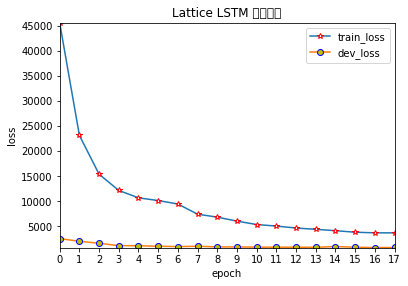

In [77]:
# encoding=utf-8
from matplotlib import pyplot
import matplotlib.pyplot as plt
#plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

 
names = range(0,18)
names = [str(x) for x in list(names)]
 
x = range(len(names))
#plt.plot(x, y, 'ro-')
#plt.plot(x, y1, 'bo-')
#pl.xlim(-1, 11)  # 限定横轴的范围
#pl.ylim(-1, 110)  # 限定纵轴的范围
 
plt.plot(x, train_loss, marker='*', mec='r', mfc='w',label='train_loss')
plt.plot(x, dev_loss, marker='o', mec='b', mfc='y',label='dev_loss')
plt.legend()  # 让图例生效
plt.xticks(x, names, rotation=1)
 
plt.margins(0)
plt.subplots_adjust(bottom=0.10)
plt.xlabel('epoch') #X轴标签
plt.ylabel("loss") #Y轴标签
#pyplot.yticks([0.750,0.800,0.850])
plt.title("Lattice LSTM 训练曲线")
#plt.savefig('D:\\f1.jpg',dpi = 900)

In [78]:
f=open('../cyx＆xy/lattice/cyx/final/test.txt','r',encoding='utf-8')
test=f.readlines()
f.close()

In [79]:
test_data=[]
test_str=[]
tt=[]
tt2=[]
for i in test:
    temp=i.split()
    if len(temp)==0:
        if len(tt)>600:
            pass
        else:
            test_data.append(tt)
            test_str.append(tt2)
        tt=[]
        tt2=[]
    else:
        tt.append(temp[-1])
        tt2.append(temp[0])

In [80]:
pre=[]
for i in _:
    pre.extend(i)

gold=[]
for i in test_data:
    gold.extend(i)

In [81]:
from sklearn.metrics import classification_report

In [82]:
print(classification_report(gold, pre, digits=4))

              precision    recall  f1-score   support

       B-MED     0.9797    0.9311    0.9548       363
       B-SYM     0.9175    0.9345    0.9259     23787
       E-MED     0.9943    0.9559    0.9747       363
       E-SYM     0.9262    0.9422    0.9341     23227
       I-MED     0.9963    0.9182    0.9557       587
       I-SYM     0.9131    0.9227    0.9179     32066
           O     0.9925    0.9864    0.9895    180150

    accuracy                         0.9696    260543
   macro avg     0.9599    0.9416    0.9504    260543
weighted avg     0.9700    0.9696    0.9698    260543

